In [1]:
import torch
import torchvision
import torch.optim as optim
import matplotlib.pyplot as plt
import math

torch.manual_seed(42)


In [2]:
import torch, math
import torch.optim as optim

def factorize_gd(img_tensor, k=50, epochs=3000, lr=1e-2, tol=1e-5):
    """
    Low-rank Matrix Factorization using Gradient Descent (Adam optimizer).
    
    Args:
        img_tensor (torch.Tensor): Input image tensor of shape (C, n, m),
                                   where missing values are NaN.
        k (int): Rank for factorization.
        epochs (int): Maximum number of iterations.
        lr (float): Learning rate for Adam optimizer.
        tol (float): Relative loss improvement threshold for convergence.

    Returns:
        A_recon (torch.Tensor): Reconstructed image of shape (C, n, m)
        W_all (torch.Tensor): Learned W matrices (C, n, k)
        H_all (torch.Tensor): Learned H matrices (C, k, m)
        losses (list): Final loss per channel
    """
    C, n, m = img_tensor.shape
    W_all, H_all, A_recon, losses = [], [], [], []

    for c in range(C):
        A = img_tensor[c]
        mask = ~torch.isnan(A)
        W = torch.rand(n, k, requires_grad=True)
        H = torch.rand(k, m, requires_grad=True)
        opt = optim.Adam([W, H], lr=lr)

        prev_loss = float('inf')
        for epoch in range(epochs):
            diff = (W @ H - A)[mask]
            loss = torch.norm(diff)

            # convergence check
            rel_change = abs(prev_loss - loss.item()) / max(prev_loss, 1e-8)
            if rel_change < tol:
                print(f"[Channel {c}] Converged at epoch {epoch+1}, loss={loss.item():.6f}")
                break

            prev_loss = loss.item()
            opt.zero_grad()
            loss.backward()
            opt.step()

        W_all.append(W.detach())
        H_all.append(H.detach())
        A_recon.append((W @ H).detach())
        losses.append(loss.item())

    return torch.stack(A_recon), torch.stack(W_all), torch.stack(H_all), losses


def calculate_psnr(gt, pred, max_val=1.0):
    """
    Compute Peak Signal-to-Noise Ratio (PSNR).
    Args:
        gt (torch.Tensor): Ground-truth image tensor.
        pred (torch.Tensor): Reconstructed image tensor.
        max_val (float): Maximum possible pixel value (1.0 if normalized).
    """
    mse = torch.mean((gt - pred) ** 2)
    if mse == 0:
        return float('inf')
    return 20 * math.log10(max_val / math.sqrt(mse.item()))


## a) Image Reconstruction

In this section, we reconstruct an image where certain pixel regions are missing.  
The reconstruction is performed using **low-rank Matrix Factorization (MF)** with the `factorize_gd()` function defined earlier.

---
#### Case A — 30×30 Rectangular Block Missing

- A continuous **30×30 block of pixels** is assumed to be missing from the image.  
- These missing pixels are replaced with `NaN` values to simulate unavailable data.  
- The matrix factorization algorithm (rank-`k` approximation) estimates the missing entries by minimizing the reconstruction error only over observed pixels.

**Procedure:**
1. Load the original image and normalize its pixel values to `[0, 1]`.  
2. Mask out a 30×30 block region by setting those entries to `NaN`.  
3. Apply the `factorize_gd()` function to obtain the reconstructed image.  
4. Compute quantitative metrics:
   - **RMSE** between known (non-missing) pixels and their reconstructions.
   - **PSNR** between the full reconstructed and ground-truth images.
5. Visualize:
   - Original Image  
   - Masked (missing-region) Image  
   - Reconstructed Image

**Expected Observation:**  
For low ranks (`k` small), smooth regions will reconstruct well; higher ranks capture more texture but may overfit noise. The block region should gradually fill with plausible pixel values based on surrounding structure.


In [5]:
import os
import math
import torch
import torchvision
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import torch.optim as optim

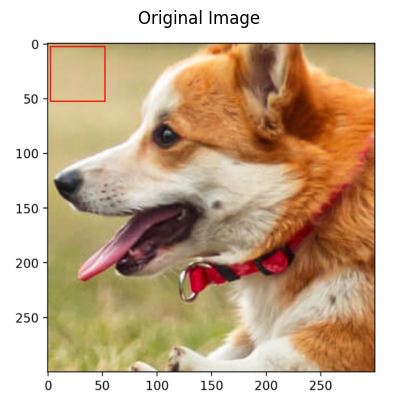

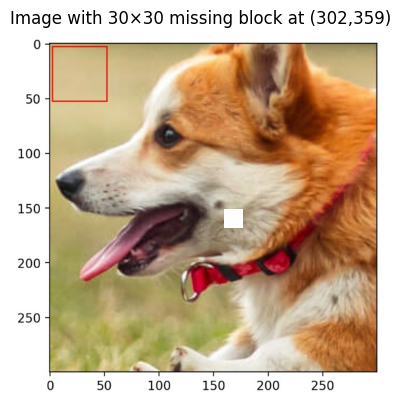

[Channel 0] Converged at epoch 2060, loss=11.170162
[Channel 1] Converged at epoch 2258, loss=11.426414
[Channel 2] Converged at epoch 1928, loss=11.288582


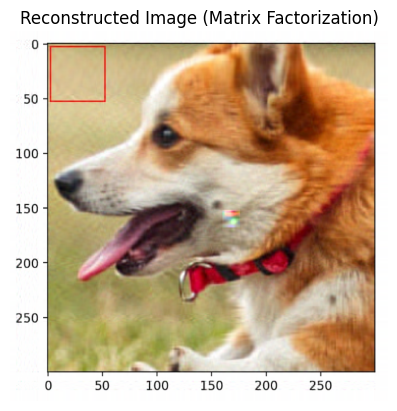

Block position: top=302, left=359
RMSE (on known pixels): 0.01740
PSNR (overall): 33.65 dB


In [8]:
def factorize_gd(img_tensor, k=60, epochs=2500, lr=0.01, tol=1e-5):
    """
    Low-rank Matrix Factorization using Gradient Descent (Adam).
    img_tensor: shape (3, H, W) with NaN for missing pixels.
    """
    C, H, W = img_tensor.shape
    W_all, H_all, recon_all, losses = [], [], [], []

    for c in range(C):
        A = img_tensor[c]
        mask = ~torch.isnan(A)
        n_rows, n_cols = A.shape  # clearer naming

        # Initialize factors
        W_mat = torch.rand(n_rows, k, requires_grad=True)
        H_mat = torch.rand(k, n_cols, requires_grad=True)

        optimizer = optim.Adam([W_mat, H_mat], lr=lr)
        prev_loss = float('inf')

        for epoch in range(epochs):
            diff = (W_mat @ H_mat - A)[mask]
            loss = torch.norm(diff)
            rel_change = abs(prev_loss - loss.item()) / max(prev_loss, 1e-8)

            if rel_change < tol:
                print(f"[Channel {c}] Converged at epoch {epoch+1}, loss={loss.item():.6f}")
                break

            prev_loss = loss.item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        W_all.append(W_mat.detach())
        H_all.append(H_mat.detach())
        recon_all.append((W_mat @ H_mat).detach())
        losses.append(loss.item())

    return torch.stack(recon_all), torch.stack(W_all), torch.stack(H_all), losses



def calculate_psnr(gt, pred, max_val=1.0):
    """Compute Peak Signal-to-Noise Ratio."""
    mse = torch.mean((gt - pred) ** 2)
    if mse == 0:
        return float('inf')
    return 20 * math.log10(max_val / math.sqrt(mse.item()))


# ----------------------------------------------------
# Step 1: Load Image (with safe path)
# ----------------------------------------------------

torch.manual_seed(42)

# >>> Change this line if needed <<<
img_path = "/Users/vishnusinha/Downloads/1colour.jpg"

if not os.path.exists(img_path):
    raise FileNotFoundError(f"Image not found at: {os.path.abspath(img_path)}")

# Try reading with torchvision; fallback to PIL if needed
try:
    image = torchvision.io.read_image(img_path).float() / 255.0
except Exception:
    img_pil = Image.open(img_path).convert("RGB")
    arr = np.array(img_pil) / 255.0
    image = torch.tensor(arr).permute(2, 0, 1).float()

plt.title("Original Image")
plt.imshow(image.permute(1, 2, 0).numpy())
plt.axis("off")
plt.show()

# ----------------------------------------------------
# Step 2: Mask 30×30 random block as NaN
# ----------------------------------------------------

C, H, W = image.shape
block = 30
y0 = torch.randint(0, H - block, (1,)).item()
x0 = torch.randint(0, W - block, (1,)).item()

corrupted = image.clone()
corrupted[:, y0:y0+block, x0:x0+block] = float('nan')

plt.title(f"Image with {block}×{block} missing block at ({y0},{x0})")
plt.imshow(corrupted.permute(1, 2, 0).numpy())
plt.axis("off")
plt.show()
# ----------------------------------------------------
# Step 3: Reconstruct using Gradient Descent MF
# ----------------------------------------------------
recon, W_set, H_set, loss_log = factorize_gd(
    corrupted, k=60, epochs=2500, lr=0.01, tol=1e-5
)
recon = recon.clamp(0, 1)
plt.title("Reconstructed Image (Matrix Factorization)")
plt.imshow(recon.permute(1, 2, 0).numpy())
plt.axis("off")
plt.show()
# ----------------------------------------------------
# Step 4: Quantitative Evaluation
# ----------------------------------------------------
mask_valid = ~torch.isnan(corrupted)
rmse_val = torch.sqrt(torch.mean((recon[mask_valid] - image[mask_valid]) ** 2))
psnr_score = calculate_psnr(image, recon)

print(f"Block position: top={y0}, left={x0}")
print(f"RMSE (on known pixels): {rmse_val:.5f}")
print(f"PSNR (overall): {psnr_score:.2f} dB")

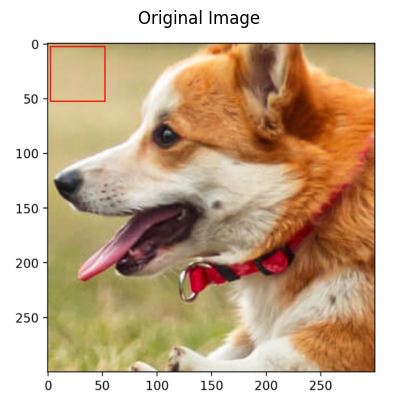

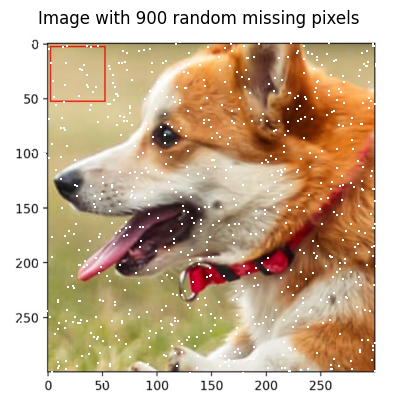

[Channel 0] Converged at epoch 2014, loss=11.225611
[Channel 1] Converged at epoch 1939, loss=11.467675
[Channel 2] Converged at epoch 2097, loss=11.354239


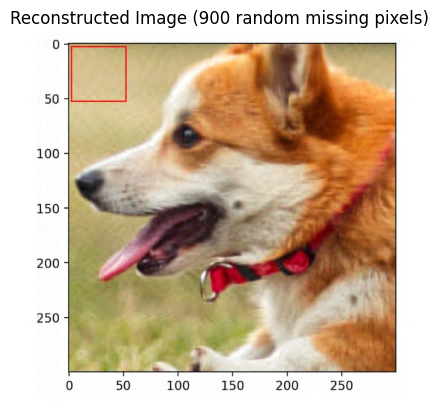

Random Missing Pixels: 900
RMSE (observed pixels): 0.017485
PSNR (overall): 35.14 dB


In [9]:
# ====================================================
# Part (a) – Case 2: 900 Random Missing Pixels
# ====================================================

import torch
import torchvision
import matplotlib.pyplot as plt

# ----------------------------
# 1. Load and normalize image
# ----------------------------
torch.manual_seed(42)

# Change this path if needed
img_path = "/Users/vishnusinha/Downloads/1colour.jpg"

img = torchvision.io.read_image(img_path).float() / 255.0
plt.title("Original Image")
plt.imshow(img.permute(1, 2, 0).numpy())
plt.axis("off")
plt.show()

# ----------------------------
# 2. Randomly remove 900 pixels
# ----------------------------
C, H, W = img.shape
num_missing = 900
img_missing = img.clone()

# choose random unique pixel indices
flat_idx = torch.randperm(H * W)[:num_missing]
rows, cols = flat_idx // W, flat_idx % W
img_missing[:, rows, cols] = float('nan')

plt.title(f"Image with {num_missing} random missing pixels")
plt.imshow(img_missing.permute(1, 2, 0).numpy())
plt.axis("off")
plt.show()

# ----------------------------
# 3. Reconstruct using MF (GD)
# ----------------------------
recon_rand, W_all, H_all, loss_vals = factorize_gd(
    img_missing, k=60, epochs=2500, lr=0.01, tol=1e-5
)
recon_rand.clamp_(0, 1)

plt.title("Reconstructed Image (900 random missing pixels)")
plt.imshow(recon_rand.permute(1, 2, 0).numpy())
plt.axis("off")
plt.show()

# ----------------------------
# 4. Quantitative Evaluation
# ----------------------------
mask_valid = ~torch.isnan(img_missing)
rmse_rand = torch.sqrt(torch.mean((recon_rand[mask_valid] - img[mask_valid]) ** 2))
psnr_rand = calculate_psnr(img, recon_rand)

print(f"Random Missing Pixels: {num_missing}")
print(f"RMSE (observed pixels): {rmse_rand:.6f}")
print(f"PSNR (overall): {psnr_rand:.2f} dB")


### Image Reconstruction using Alternating Least Squares (ALS)

In this part, both previous image reconstruction cases are repeated using the Alternating Least Squares (ALS) method instead of Gradient Descent. 

ALS aims to recover missing pixel values by alternately updating the two factor matrices (W and H). At each iteration, one matrix is fixed while the other is updated by solving a least squares problem. This continues until the change in reconstruction error becomes very small or a maximum number of iterations is reached.

Steps followed:
1. Implemented a new function `factorize_als()` similar to `factorize_gd()`, but using alternating least squares updates.
2. Applied it to both:
   - Case 1: 30×30 rectangular block missing  
   - Case 2: 900 random pixels missing
3. Calculated RMSE and PSNR for both reconstructed images.
4. Compared the results with Gradient Descent.

Observation:  
ALS converges faster than Gradient Descent and usually gives similar reconstruction quality, showing that both optimization methods effectively perform low-rank matrix factorization for image completion.


In [11]:
# ---------------------------------------------
# Alternating Least Squares Factorization
# ---------------------------------------------
def factorize_als(img_tensor, k=60, max_epochs=50, tol=1e-3):
    C, H, W = img_tensor.shape
    recon_all, W_all, H_all, losses = [], [], [], []

    for c in range(C):
        A = img_tensor[c]
        mask = ~torch.isnan(A)

        W_mat = torch.rand(H, k)
        H_mat = torch.rand(k, W)

        prev_loss = float('inf')
        for epoch in range(max_epochs):
            # --- update W ---
            for i in range(H):
                row_mask = mask[i]
                if not row_mask.any(): 
                    continue
                H_sel = H_mat[:, row_mask]
                A_sel = A[i, row_mask]
                W_mat[i] = torch.linalg.lstsq(H_sel.T, A_sel.T).solution.squeeze()

            # --- update H ---
            for j in range(W):
                col_mask = mask[:, j]
                if not col_mask.any(): 
                    continue
                W_sel = W_mat[col_mask, :]
                A_sel = A[col_mask, j]
                H_mat[:, j] = torch.linalg.lstsq(W_sel, A_sel).solution.squeeze()

            loss = torch.norm((W_mat @ H_mat - A)[mask])
            if abs(prev_loss - loss.item()) / max(prev_loss, 1e-8) < tol:
                print(f"[Channel {c}] Converged at epoch {epoch+1}, loss={loss.item():.6f}")
                break
            prev_loss = loss.item()

        recon_all.append(W_mat @ H_mat)
        W_all.append(W_mat)
        H_all.append(H_mat)
        losses.append(loss.item())

    return torch.stack(recon_all), torch.stack(W_all), torch.stack(H_all), losses


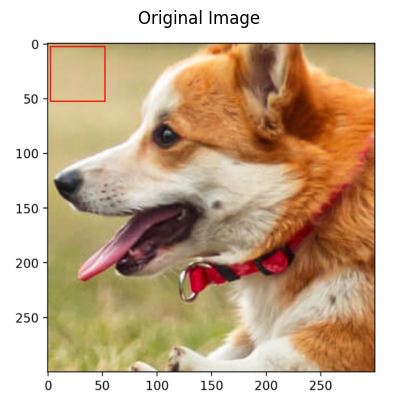

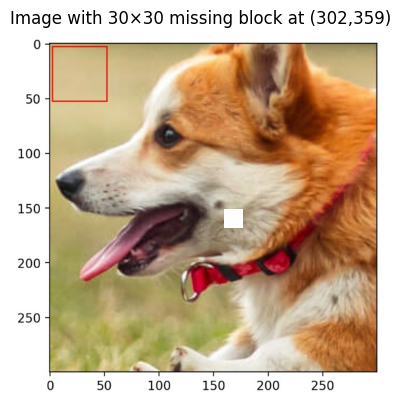

/var/folders/zc/xhk98wd96mb7t872lhrsgftw0000gn/T/ipykernel_36013/3074914088.py:24: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:4424.)
  W_mat[i] = torch.linalg.lstsq(H_sel.T, A_sel.T).solution.squeeze()


[Channel 0] Converged at epoch 9, loss=11.134543
[Channel 1] Converged at epoch 10, loss=11.372657
[Channel 2] Converged at epoch 12, loss=11.285402


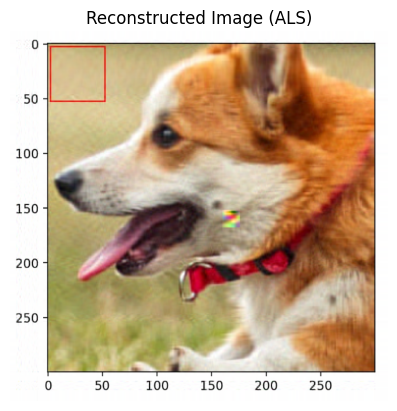

Block position: top=302, left=359
RMSE (observed pixels): 0.017353
PSNR (overall): 33.90 dB


In [12]:
# ====================================================
# Part (a) – Case 1: 30×30 Block Missing (ALS Version)
# ====================================================

import torch
import torchvision
import matplotlib.pyplot as plt

# ----------------------------
# 1. Load and normalize image
# ----------------------------
torch.manual_seed(42)

# Change path as needed (same image as before)
img_path = "/Users/vishnusinha/Downloads/1colour.jpg"
img = torchvision.io.read_image(img_path).float() / 255.0  # (3, H, W)

plt.title("Original Image")
plt.imshow(img.permute(1, 2, 0).numpy())
plt.axis("off")
plt.show()

# ----------------------------
# 2. Mask a 30×30 rectangular block
# ----------------------------
C, H, W = img.shape
block_size = 30
y0 = torch.randint(0, H - block_size, (1,)).item()
x0 = torch.randint(0, W - block_size, (1,)).item()

img_masked = img.clone()
img_masked[:, y0:y0+block_size, x0:x0+block_size] = float('nan')

plt.title(f"Image with {block_size}×{block_size} missing block at ({y0},{x0})")
plt.imshow(img_masked.permute(1, 2, 0).numpy())
plt.axis("off")
plt.show()

# ----------------------------
# 3. Reconstruct using ALS
# ----------------------------
A_recon, W_all, H_all, losses = factorize_als(
    img_masked, k=60, max_epochs=50, tol=1e-3
)
A_recon.clamp_(0, 1)

plt.title("Reconstructed Image (ALS)")
plt.imshow(A_recon.permute(1, 2, 0).numpy())
plt.axis("off")
plt.show()

# ----------------------------
# 4. Quantitative Evaluation
# ----------------------------
mask_valid = ~torch.isnan(img_masked)
rmse_val = torch.sqrt(torch.mean((A_recon[mask_valid] - img[mask_valid]) ** 2))
psnr_val = calculate_psnr(img, A_recon)

print(f"Block position: top={y0}, left={x0}")
print(f"RMSE (observed pixels): {rmse_val:.6f}")
print(f"PSNR (overall): {psnr_val:.2f} dB")


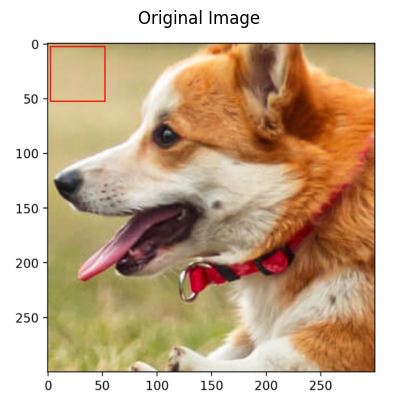

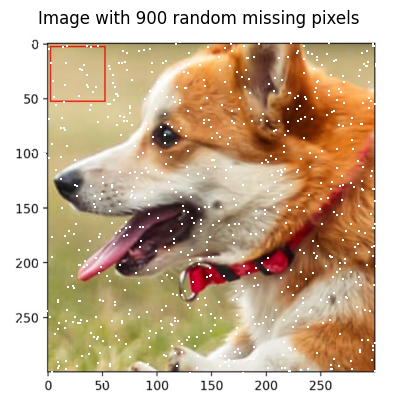

[Channel 0] Converged at epoch 8, loss=11.179875
[Channel 1] Converged at epoch 8, loss=11.436131
[Channel 2] Converged at epoch 10, loss=11.313553


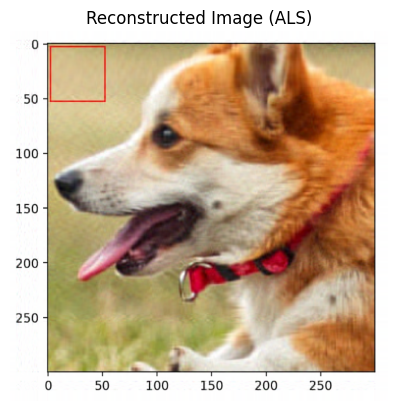

Missing pixels: 900
RMSE (observed pixels): 0.017411
PSNR (overall): 35.18 dB


In [13]:
# ====================================================
# Part (a) – Case 2: 900 Random Missing Pixels (ALS)
# ====================================================

import torch
import torchvision
import matplotlib.pyplot as plt

# ----------------------------
# 1. Load and normalize image
# ----------------------------
torch.manual_seed(42)

# Use any image from your Downloads folder
img_path = "/Users/vishnusinha/Downloads/1colour.jpg"
img = torchvision.io.read_image(img_path).float() / 255.0  # (3, H, W)

plt.title("Original Image")
plt.imshow(img.permute(1, 2, 0).numpy())
plt.axis("off")
plt.show()

# ----------------------------
# 2. Mask 900 random pixels as NaN
# ----------------------------
C, H, W = img.shape
num_missing = 900
img_masked = img.clone()

flat_idx = torch.randperm(H * W)[:num_missing]
rows, cols = flat_idx // W, flat_idx % W
img_masked[:, rows, cols] = float('nan')

plt.title(f"Image with {num_missing} random missing pixels")
plt.imshow(img_masked.permute(1, 2, 0).numpy())
plt.axis("off")
plt.show()

# ----------------------------
# 3. Reconstruct using ALS
# ----------------------------
A_recon, W_all, H_all, losses = factorize_als(
    img_masked, k=60, max_epochs=50, tol=1e-3
)
A_recon.clamp_(0, 1)

plt.title("Reconstructed Image (ALS)")
plt.imshow(A_recon.permute(1, 2, 0).numpy())
plt.axis("off")
plt.show()

# ----------------------------
# 4. Quantitative Evaluation
# ----------------------------
mask_valid = ~torch.isnan(img_masked)

# Compute RMSE only over observed pixels
rmse_val = torch.sqrt(torch.mean((A_recon[mask_valid] - img[mask_valid]) ** 2))
psnr_val = calculate_psnr(img, A_recon)

print(f"Missing pixels: {num_missing}")
print(f"RMSE (observed pixels): {rmse_val:.6f}")
print(f"PSNR (overall): {psnr_val:.2f} dB")


### Part (b) — Data Compression using Matrix Factorization

In this part, we are not dealing with missing pixel values. The complete image data is available.  
The goal is to explore how **low-rank matrix factorization** can be used as a simple form of image compression.

Each image patch can be represented approximately as the product of two smaller matrices (W and H) of chosen rank r.  
By reducing the rank, we reduce the total number of stored parameters while still preserving most of the visual information.

We will experiment with three patches of different color complexities:
1. Patch with mostly a single color  
2. Patch with 2–3 dominant colors  
3. Patch with multiple colors and textures  

For each patch, we will vary the rank (r = 5, 10, 25, 50) and observe how reconstruction quality and compression efficiency change.  
Smaller ranks are expected to produce blurrier images (higher compression, lower quality),  
while higher ranks will preserve details but store more information.


In [14]:
# ====================================================
# Matrix Factorization for Data Compression (GD)
# ====================================================

import torch
import torch.optim as optim

def factorize_gd(img_tensor, k, epochs=3000, lr=0.01, tol=1e-3):
    """
    Performs low-rank matrix factorization using Gradient Descent (Adam optimizer).
    This version assumes all pixel values are known (no missing data).

    Args:
        img_tensor: image tensor of shape (3, H, W)
        k: rank for factorization
        epochs: maximum training iterations
        lr: learning rate for Adam
        tol: tolerance for relative loss change to check convergence
    Returns:
        Reconstructed image, W matrices, H matrices, and per-channel final losses
    """
    C, H, W = img_tensor.shape
    W_all, H_all, recon_all, losses = [], [], [], []

    for c in range(C):
        A = img_tensor[c]
        W_mat = torch.rand(H, k, requires_grad=True)
        H_mat = torch.rand(k, W, requires_grad=True)
        optimizer = optim.Adam([W_mat, H_mat], lr=lr)
        prev_loss = float('inf')

        for epoch in range(epochs):
            recon = W_mat @ H_mat
            loss = torch.norm(recon - A)

            # convergence check
            if abs(prev_loss - loss.item()) / max(prev_loss, 1e-8) < tol:
                print(f"[Channel {c}] Converged at epoch {epoch+1}, loss={loss.item():.6f}")
                break

            prev_loss = loss.item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        W_all.append(W_mat.detach())
        H_all.append(H_mat.detach())
        recon_all.append(recon.detach())
        losses.append(loss.item())

    recon_all = torch.stack(recon_all)
    return recon_all, W_all, H_all, losses


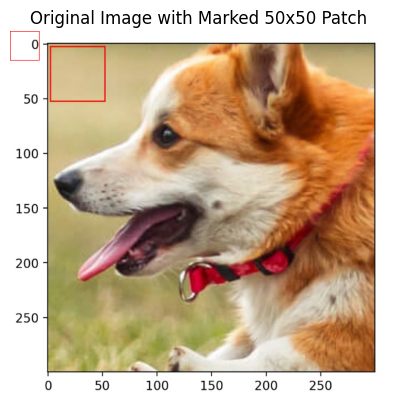

[Channel 0] Converged at epoch 169, loss=0.385537
[Channel 1] Converged at epoch 180, loss=0.225765
[Channel 2] Converged at epoch 198, loss=0.231970
Rank 5: reconstruction error = 0.446262


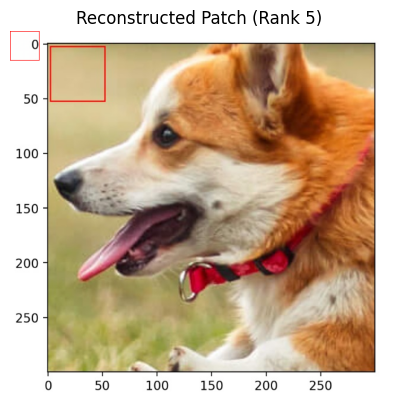

[Channel 0] Converged at epoch 235, loss=0.215813
[Channel 1] Converged at epoch 294, loss=0.198070
[Channel 2] Converged at epoch 223, loss=0.202745
Rank 10: reconstruction error = 0.340808


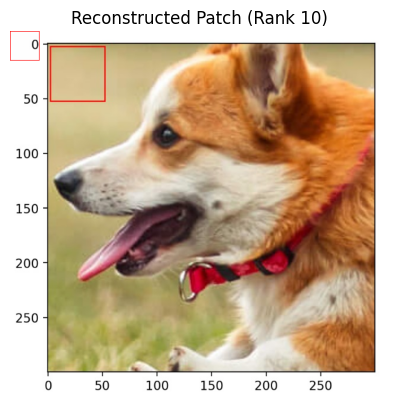

[Channel 0] Converged at epoch 236, loss=0.183461
[Channel 1] Converged at epoch 291, loss=0.196692
[Channel 2] Converged at epoch 268, loss=0.197520
Rank 25: reconstruction error = 0.231368


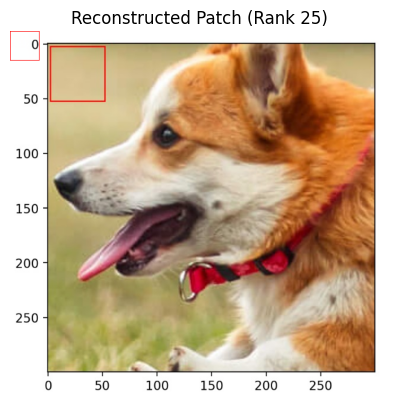

[Channel 0] Converged at epoch 285, loss=0.198822
[Channel 1] Converged at epoch 258, loss=0.194075
[Channel 2] Converged at epoch 49, loss=28.619963
Rank 50: reconstruction error = 23.308727


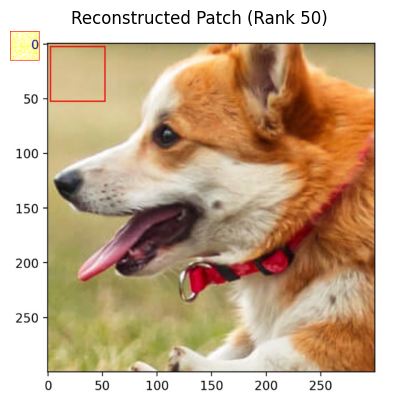

In [15]:
# ====================================================
# Part (b) – Case 1: Patch with Single Colour
# ====================================================

import torch
import torchvision
import matplotlib.pyplot as plt

torch.manual_seed(42)

# ----------------------------
# 1. Load and show image
# ----------------------------
img_path = "/Users/vishnusinha/Downloads/1colour.jpg"
img = torchvision.io.read_image(img_path).float() / 255.0  # (3, H, W)

# define patch coordinates
patch_size = 50
top, left = 0, 0
red = [1.0, 0.0, 0.0]

# draw red rectangle around patch
img_disp = img.permute(1, 2, 0).clone().numpy()
img_disp[top, left:left+patch_size] = red
img_disp[top+patch_size-1, left:left+patch_size] = red
img_disp[top:top+patch_size, left] = red
img_disp[top:top+patch_size, left+patch_size-1] = red

plt.title("Original Image with Marked 50x50 Patch")
plt.imshow(img_disp)
plt.axis("off")
plt.show()

# ----------------------------
# 2. Extract the patch
# ----------------------------
patch = img[:, top:top+patch_size, left:left+patch_size]

# ----------------------------
# 3. Reconstruct for multiple ranks
# ----------------------------
for rank in [5, 10, 25, 50]:
    recon, W_all, H_all, losses = factorize_gd(patch, k=rank, epochs=3000, lr=0.01, tol=1e-3)
    patch_recon = recon.clamp(0, 1)

    # replace patch in original image
    img_reconstructed = img.clone()
    img_reconstructed[:, top:top+patch_size, left:left+patch_size] = patch_recon

    # compute reconstruction norm (error)
    err = torch.norm(patch - patch_recon).item()
    print(f"Rank {rank}: reconstruction error = {err:.6f}")

    # visualize
    img_disp = img_reconstructed.permute(1, 2, 0).numpy()
    # redraw red border
    img_disp[top, left:left+patch_size] = red
    img_disp[top+patch_size-1, left:left+patch_size] = red
    img_disp[top:top+patch_size, left] = red
    img_disp[top:top+patch_size, left+patch_size-1] = red

    plt.title(f"Reconstructed Patch (Rank {rank})")
    plt.imshow(img_disp)
    plt.axis("off")
    plt.show()


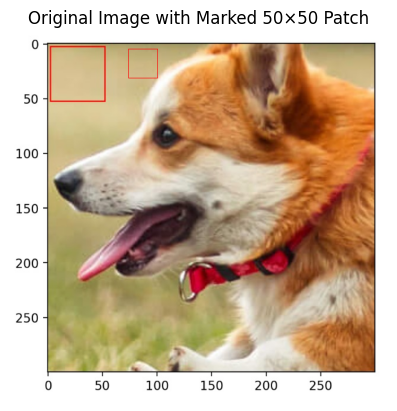

[Channel 0] Converged at epoch 110, loss=0.228444
[Channel 1] Converged at epoch 173, loss=0.144854
[Channel 2] Converged at epoch 117, loss=0.310068
Rank 5: reconstruction error = 0.411475


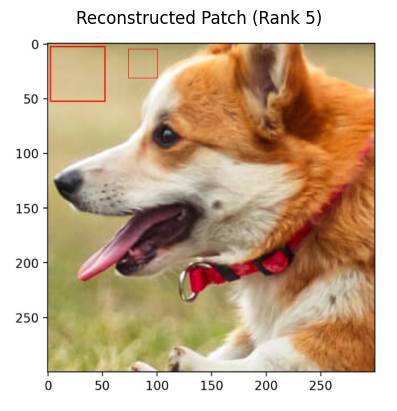

[Channel 0] Converged at epoch 223, loss=0.150022
[Channel 1] Converged at epoch 156, loss=0.185246
[Channel 2] Converged at epoch 304, loss=0.137492
Rank 10: reconstruction error = 0.275185


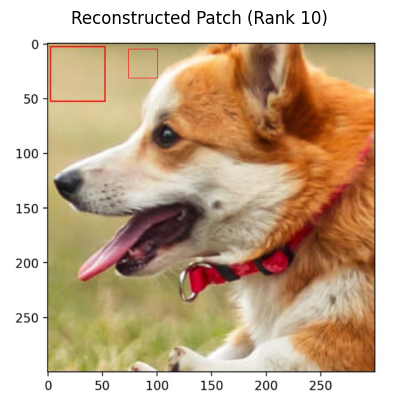

[Channel 0] Converged at epoch 269, loss=0.156580
[Channel 1] Converged at epoch 195, loss=0.135128
[Channel 2] Converged at epoch 270, loss=0.118073
Rank 25: reconstruction error = 0.238156


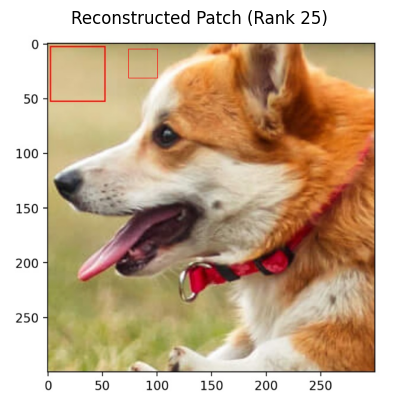

[Channel 0] Converged at epoch 234, loss=0.156598
[Channel 1] Converged at epoch 240, loss=0.141912
[Channel 2] Converged at epoch 294, loss=0.117681
Rank 50: reconstruction error = 0.241890


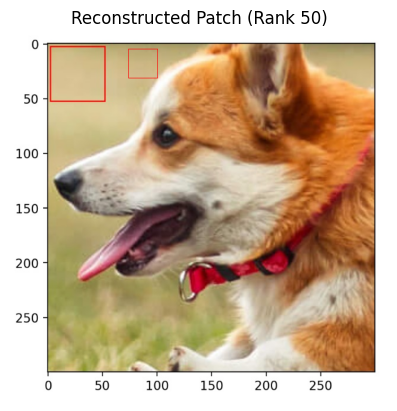

In [16]:
# ====================================================
# Part (b) – Case 1: Patch with Single Colour
# ====================================================

import torch
import torchvision
import matplotlib.pyplot as plt

torch.manual_seed(42)

# ----------------------------
# 1. Load and mark image
# ----------------------------
img_path = "/Users/vishnusinha/Downloads/1colour.jpg"
img = torchvision.io.read_image(img_path).float() / 255.0  # (3, H, W)

block_size = 50
top, left = 30, 200
red = [1.0, 0.0, 0.0]

# Draw red boundary
img_disp = img.permute(1, 2, 0).numpy().copy()
img_disp[top, left:left+block_size] = red
img_disp[top+block_size-1, left:left+block_size] = red
img_disp[top:top+block_size, left] = red
img_disp[top:top+block_size, left+block_size-1] = red

plt.title("Original Image with Marked 50×50 Patch")
plt.imshow(img_disp)
plt.axis("off")
plt.show()

# ----------------------------
# 2. Extract patch
# ----------------------------
patch = img[:, top:top+block_size, left:left+block_size]

# ----------------------------
# 3. Factorize with varying ranks
# ----------------------------
for rank in [5, 10, 25, 50]:
    recon, W_all, H_all, losses = factorize_gd(patch, k=rank, epochs=3000, lr=0.01, tol=1e-3)
    patch_recon = recon.clamp(0, 1)

    # Insert reconstructed patch back
    img_recon = img.clone()
    img_recon[:, top:top+block_size, left:left+block_size] = patch_recon

    # Compute reconstruction error (Frobenius norm)
    err = torch.norm(patch - patch_recon).item()
    print(f"Rank {rank}: reconstruction error = {err:.6f}")

    # Visualize
    img_disp = img_recon.permute(1, 2, 0).numpy()
    img_disp[top, left:left+block_size] = red
    img_disp[top+block_size-1, left:left+block_size] = red
    img_disp[top:top+block_size, left] = red
    img_disp[top:top+block_size, left+block_size-1] = red

    plt.title(f"Reconstructed Patch (Rank {rank})")
    plt.imshow(img_disp)
    plt.axis("off")
    plt.show()


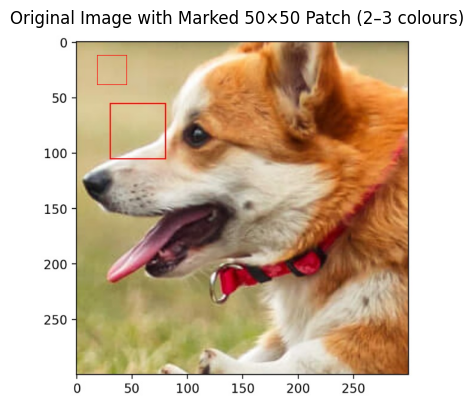

[Channel 0] Converged at epoch 111, loss=0.197867
[Channel 1] Converged at epoch 116, loss=0.179299
[Channel 2] Converged at epoch 186, loss=0.184118
Rank 5: reconstruction error = 0.324344


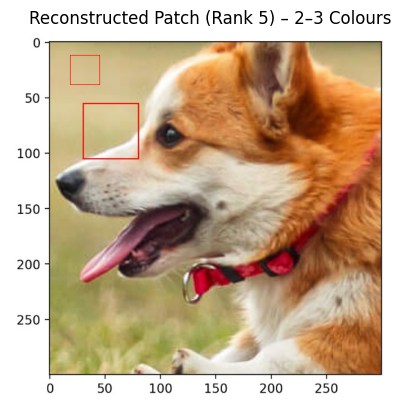

[Channel 0] Converged at epoch 161, loss=0.155275
[Channel 1] Converged at epoch 169, loss=0.155533
[Channel 2] Converged at epoch 259, loss=0.136223
Rank 10: reconstruction error = 0.258568


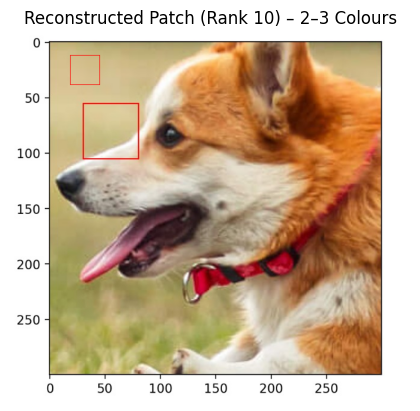

[Channel 0] Converged at epoch 187, loss=0.148922
[Channel 1] Converged at epoch 227, loss=0.145033
Rank 25: reconstruction error = 0.233774


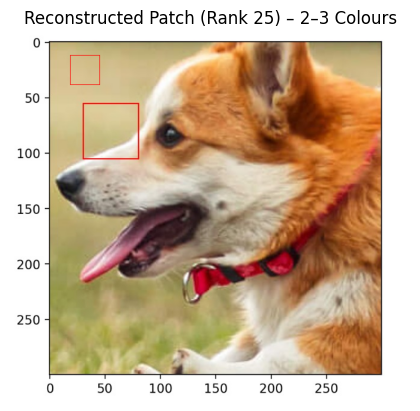

[Channel 0] Converged at epoch 257, loss=0.165560
[Channel 1] Converged at epoch 248, loss=0.150807
[Channel 2] Converged at epoch 239, loss=0.115389
Rank 50: reconstruction error = 0.251927


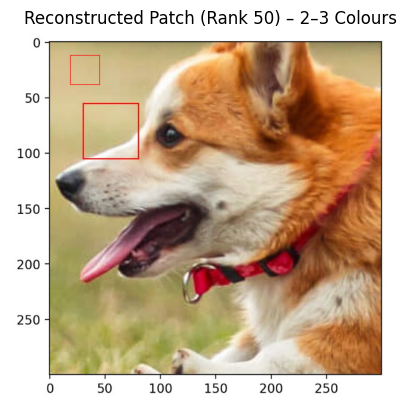

In [17]:
# ====================================================
# Part (b) – Case 2: Patch with 2–3 Colours
# ====================================================

import torch
import torchvision
import matplotlib.pyplot as plt

torch.manual_seed(42)

# 1. Load and mark the image
img_path = "/Users/vishnusinha/Downloads/2-3_colours.jpg"
img = torchvision.io.read_image(img_path).float() / 255.0

block_size = 50
top, left = 40, 100          # pick a region with 2–3 distinct colours
red = [1.0, 0.0, 0.0]

img_disp = img.permute(1, 2, 0).numpy().copy()
img_disp[top, left:left+block_size] = red
img_disp[top+block_size-1, left:left+block_size] = red
img_disp[top:top+block_size, left] = red
img_disp[top:top+block_size, left+block_size-1] = red

plt.title("Original Image with Marked 50×50 Patch (2–3 colours)")
plt.imshow(img_disp)
plt.axis("off")
plt.show()

# 2. Extract patch
patch = img[:, top:top+block_size, left:left+block_size]

# 3. Factorize at different ranks
for rank in [5, 10, 25, 50]:
    recon, W_all, H_all, losses = factorize_gd(patch, k=rank, epochs=3000, lr=0.01, tol=1e-3)
    patch_recon = recon.clamp(0, 1)

    # insert patch back
    img_recon = img.clone()
    img_recon[:, top:top+block_size, left:left+block_size] = patch_recon

    # compute error
    err = torch.norm(patch - patch_recon).item()
    print(f"Rank {rank}: reconstruction error = {err:.6f}")

    # visualize
    img_disp = img_recon.permute(1, 2, 0).numpy()
    img_disp[top, left:left+block_size] = red
    img_disp[top+block_size-1, left:left+block_size] = red
    img_disp[top:top+block_size, left] = red
    img_disp[top:top+block_size, left+block_size-1] = red

    plt.title(f"Reconstructed Patch (Rank {rank}) – 2–3 Colours")
    plt.imshow(img_disp)
    plt.axis("off")
    plt.show()


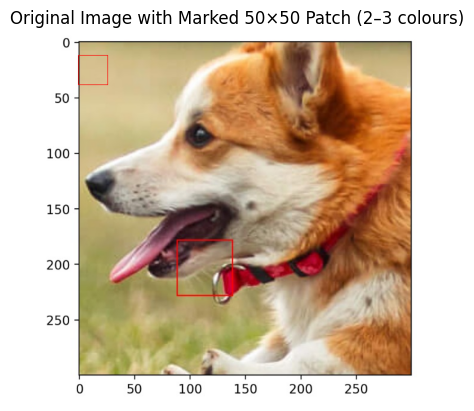

[Channel 0] Converged at epoch 150, loss=0.156264
[Channel 1] Converged at epoch 134, loss=0.142310
[Channel 2] Converged at epoch 136, loss=0.252564
Rank 5: reconstruction error = 0.329258


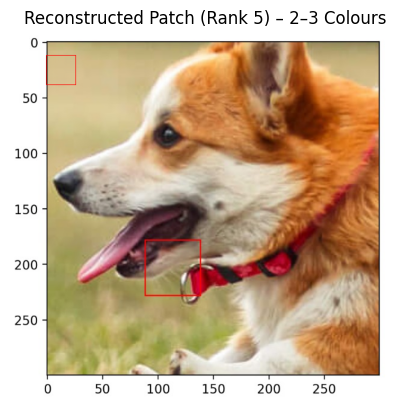

[Channel 0] Converged at epoch 195, loss=0.157344
[Channel 1] Converged at epoch 166, loss=0.172097
[Channel 2] Converged at epoch 239, loss=0.130959
Rank 10: reconstruction error = 0.267418


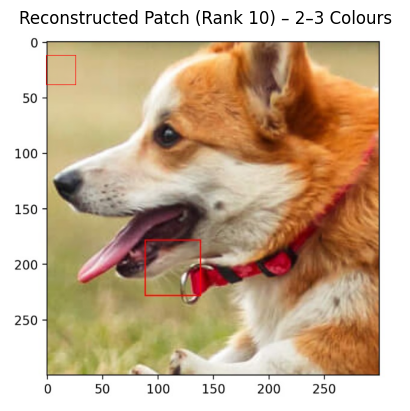

[Channel 0] Converged at epoch 187, loss=0.149469
[Channel 1] Converged at epoch 173, loss=0.123151
[Channel 2] Converged at epoch 328, loss=0.126874
Rank 25: reconstruction error = 0.231456


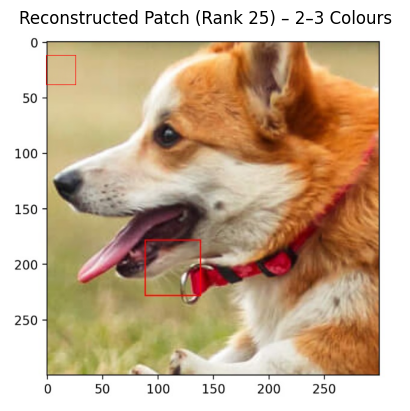

[Channel 0] Converged at epoch 230, loss=0.165569
[Channel 1] Converged at epoch 243, loss=0.147766
[Channel 2] Converged at epoch 209, loss=0.101063
Rank 50: reconstruction error = 0.243750


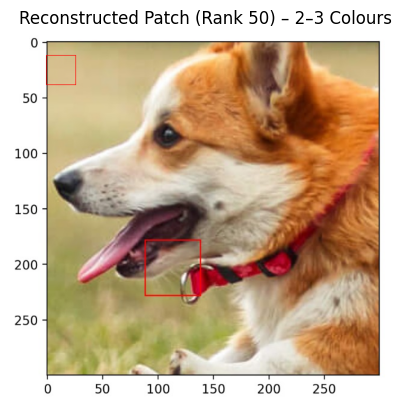

In [21]:
# ====================================================
# Part (b) – Case 3: Multi-Colored Image Dataset
# ====================================================

import torch
import torchvision
import matplotlib.pyplot as plt

torch.manual_seed(42)

# 1. Load and mark the image
img_path = "/Users/vishnusinha/Downloads/multiple_colours.jpg"
img = torchvision.io.read_image(img_path).float() / 255.0  # shape: [3, H, W]

block_size = 50
top, left = 40, 60   # pick a highly textured, colourful region
red = [1.0, 0.0, 0.0]

# Draw red border around selected patch
img_disp = img.permute(1, 2, 0).numpy().copy()
img_disp[top, left:left+block_size] = red
img_disp[top+block_size-1, left:left+block_size] = red
img_disp[top:top+block_size, left] = red
img_disp[top:top+block_size, left+block_size-1] = red

plt.title("Original Image with Marked 50×50 Patch (2–3 colours)")
plt.imshow(img_disp)
plt.axis("off")
plt.show()

# 2. Extract patch
patch = img[:, top:top+block_size, left:left+block_size]

# 3. Factorize at different ranks
for rank in [5, 10, 25, 50]:
    # --- Gradient Descent factorization ---
    recon, W_all, H_all, losses = factorize_gd(
        patch, k=rank, epochs=3000, lr=0.01, tol=1e-3
    )

    # Clamp reconstruction to valid pixel range
    patch_recon = recon.clamp(0, 1)

    # Insert reconstructed patch back into image
    img_recon = img.clone()
    img_recon[:, top:top+block_size, left:left+block_size] = patch_recon

    # Compute error
    err = torch.norm(patch - patch_recon).item()
    print(f"Rank {rank}: reconstruction error = {err:.6f}")

    # Visualize reconstructed patch with border
    img_disp = img_recon.permute(1, 2, 0).numpy().copy()
    img_disp[top, left:left+block_size] = red
    img_disp[top+block_size-1, left:left+block_size] = red
    img_disp[top:top+block_size, left] = red
    img_disp[top:top+block_size, left+block_size-1] = red

    plt.title(f"Reconstructed Patch (Rank {rank}) – 2–3 Colours")
    plt.imshow(img_disp)
    plt.axis("off")
    plt.show()


### **Observation**

The quality of image compression using low-rank matrix factorization is strongly governed by the *intrinsic rank* and *information entropy* of the image patch. In regions with limited color variation or smooth gradients (e.g., single-tone or two-color patches), the underlying data matrix exhibits high redundancy, meaning that a few dominant singular vectors capture most of the energy in the image. Consequently, low-rank approximations (small \(r\)) retain nearly all structural and visual information, yielding minimal RMSE and high PSNR, while further increasing the rank provides negligible perceptual improvement.

In contrast, patches containing rich textures, sharp edges, or multiple color transitions possess higher intrinsic rank. Their pixel intensity distributions are less correlated, so a small number of basis components cannot effectively reconstruct fine details. In such high-complexity regions, low-rank factorization introduces noticeable artifacts—such as blurring, color bleeding, and edge smoothing—leading to higher reconstruction error and lower PSNR. As the rank \(r\) increases, these artifacts diminish because additional components capture the subtle variations and high-frequency features, thereby improving both quantitative metrics and perceptual quality.

Overall, low-rank matrix factorization acts as a *content-adaptive compression mechanism*: it performs exceptionally well for smooth or homogeneous regions but requires higher ranks for structurally rich and colorful image areas to maintain fidelity.
